In [1]:
#Importing libraries
import pygame
import neat
import time
import os
import random
import visualize

from IPython.display import display, SVG

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#Generation counter
generation = 0

#Game window dimensions
screen_width = 500
screen_height = 800

In [3]:
#Importing image assets
ship_sprites = [
    pygame.transform.scale2x(pygame.image.load(os.path.join("assets", "ship1.png"))),
    pygame.transform.scale2x(pygame.image.load(os.path.join("assets", "ship2.png"))),
    pygame.transform.scale2x(pygame.image.load(os.path.join("assets", "ship3.png")))
]
laser_img = pygame.transform.scale2x(pygame.image.load(os.path.join("assets", "laser.png")))
planet_img = pygame.transform.scale2x(pygame.image.load(os.path.join("assets", "planet.png")))
background_img = pygame.transform.scale2x(pygame.image.load(os.path.join("assets", "background.png")))

In [4]:
#Game fonts
pygame.font.init()  # Initialize font module
info_font = pygame.font.SysFont("roboto", 40)

In [5]:
#Creating the ship class
class Ship:
    sprites = ship_sprites  # Use the renamed variable for ship images
    max_angle = 25
    rotation_speed = 20
    animation_duration = 5

    def __init__(self, position_x, position_y):
        self.position_x = position_x
        self.position_y = position_y
        self.angle = 0
        self.elapsed_ticks = 0
        self.velocity = 0
        self.initial_height = self.position_y
        self.current_sprite_index = 0
        self.current_sprite = self.sprites[0]

    def ascend(self):
        self.velocity = -10.5
        self.elapsed_ticks = 0
        self.initial_height = self.position_y

    def navigate(self):
        self.elapsed_ticks += 1

        displacement = self.velocity * self.elapsed_ticks + 1.5 * self.elapsed_ticks ** 2

        if displacement >= 16:
            displacement = 16

        if displacement < 0:
            displacement -= 2

        self.position_y += displacement

        if displacement < 0 or self.position_y < self.initial_height + 50:
            if self.angle < self.max_angle:
                self.angle = self.max_angle
        else:
            if self.angle > -90:
                self.angle -= self.rotation_speed
                
    def render(self, window):
        self.current_sprite_index += 1

        if self.current_sprite_index < self.animation_duration:
            self.current_sprite = self.sprites[0]
        elif self.current_sprite_index < self.animation_duration * 2:
            self.current_sprite = self.sprites[1]
        elif self.current_sprite_index < self.animation_duration * 3:
            self.current_sprite = self.sprites[2]
        elif self.current_sprite_index < self.animation_duration * 4:
            self.current_sprite = self.sprites[1]
        elif self.current_sprite_index == self.animation_duration * 4 + 1:
            self.current_sprite = self.sprites[0]
            self.current_sprite_index = 0

        if self.angle <= -80:
            self.current_sprite = self.sprites[1]
            self.current_sprite_index = self.animation_duration * 2

        # Adjust rotation and blit
        rotated_sprite = pygame.transform.rotate(self.current_sprite, self.angle)
        new_rect = rotated_sprite.get_rect(center=self.current_sprite.get_rect(topleft=(self.position_x, self.position_y)).center)
        window.blit(rotated_sprite, new_rect.topleft)

    def collision_mask(self):
        return pygame.mask.from_surface(self.current_sprite)

In [6]:
#Creating the laser class
class Laser:
    spacing = 200
    speed = 5

    def __init__(self, position_x):
        self.position_x = position_x
        self.column_height = 0
        self.upper_end = 0
        self.lower_end = 0
        self.upper_laser = pygame.transform.flip(laser_img, False, True)
        self.lower_laser = laser_img
        self.has_passed = False
        self.initialize_height()

    def initialize_height(self):
        self.column_height = random.randrange(50, 450)
        self.upper_end = self.column_height - self.upper_laser.get_height()
        self.lower_end = self.column_height + self.spacing

    def navigate(self):
        self.position_x -= self.speed

    def render(self, window):
        window.blit(self.upper_laser, (self.position_x, self.upper_end))
        window.blit(self.lower_laser, (self.position_x, self.lower_end))

    def check_collision(self, spacecraft):
        spacecraft_mask = spacecraft.collision_mask()
        upper_mask = pygame.mask.from_surface(self.upper_laser)
        lower_mask = pygame.mask.from_surface(self.lower_laser)

        upper_offset = (self.position_x - spacecraft.position_x, self.upper_end - round(spacecraft.position_y))
        lower_offset = (self.position_x - spacecraft.position_x, self.lower_end - round(spacecraft.position_y))

        collision_with_lower = spacecraft_mask.overlap(lower_mask, lower_offset)
        collision_with_upper = spacecraft_mask.overlap(upper_mask, upper_offset)

        return collision_with_upper or collision_with_lower

In [7]:
#Creating the planet class
class Planet:
    speed = 5
    image_width = planet_img.get_width()
    texture = planet_img

    def __init__(self, position_y):
        self.position_y = position_y
        self.position_x1 = 0
        self.position_x2 = self.image_width
    
    def navigate(self):
        self.position_x1 -= self.speed
        self.position_x2 -= self.speed
        
        # Reset positions to simulate continuous scroll
        if self.position_x1 + self.image_width < 0:
            self.position_x1 = self.position_x2 + self.image_width
            
        if self.position_x2 + self.image_width < 0:
            self.position_x2 = self.position_x1 + self.image_width

    def render(self, window):
        window.blit(self.texture, (self.position_x1, self.position_y))
        window.blit(self.texture, (self.position_x2, self.position_y))

In [8]:
#Drowing the game window
def render_window(window, spacecrafts, projectiles, planet, score, generation):
    window.blit(background_img, (0, 0))

    for projectile in projectiles:
        projectile.render(window)

    # Display the score
    score_text = info_font.render("Score: " + str(score), True, (255, 255, 255))
    window.blit(score_text, (screen_width - 10 - score_text.get_width(), 10))

    # Display the generation
    gen_text = info_font.render("Gen: " + str(generation), True, (255, 255, 255))
    window.blit(gen_text, (10, 10))

    #Display the alive spacecrafts
    alive_text = info_font.render("Alive: " + str(len(spacecrafts)), True, (255, 255, 255))
    window.blit(alive_text, (10, 50))
    
    planet.render(window)

    for spacecraft in spacecrafts:
        spacecraft.render(window)

    pygame.display.update()

In [9]:
#Main game function
def main(genomes, config):
    global generation
    generation += 1

    neural_networks = []
    genetic_engines = []
    spacecrafts = []

    for _, genome in genomes:
        network = neat.nn.FeedForwardNetwork.create(genome, config)
        neural_networks.append(network)
        spacecrafts.append(Ship(230, 350))  # Assuming Ship class is unchanged
        genome.fitness = 0
        genetic_engines.append(genome)

    planet = Planet(730)  
    lasers = [Laser(600)] 
    window = pygame.display.set_mode((screen_width, screen_height))
    active = True
    clock = pygame.time.Clock()

    score = 0

    while active and len(spacecrafts) > 0:
        clock.tick(30)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                active = False
                pygame.quit()
                quit()

        laser_index = 0
        if len(spacecrafts) > 0:
            if len(lasers) > 1 and spacecrafts[0].position_x > lasers[0].position_x + lasers[0].upper_laser.get_width():
                laser_index = 1

        for ii, spacecraft in enumerate(spacecrafts):
            spacecraft.navigate() 
            genetic_engines[ii].fitness += 0.1
            output = neural_networks[ii].activate((spacecraft.position_y, abs(spacecraft.position_y - lasers[laser_index].column_height), abs(spacecraft.position_y - lasers[laser_index].lower_end)))

            if output[0] > 0.5:
                spacecraft.ascend()  

        planet.navigate()  
        add_laser = False
        to_remove = []
        for laser in lasers:
            for ii, spacecraft in enumerate(spacecrafts):
                if laser.check_collision(spacecraft):  
                    genetic_engines[ii].fitness -= 1
                    spacecrafts.pop(ii)
                    neural_networks.pop(ii)
                    genetic_engines.pop(ii)
                if not laser.has_passed and laser.position_x < spacecraft.position_x:
                    laser.has_passed = True
                    add_laser = True

            if laser.position_x + laser.upper_laser.get_width() < 0:
                to_remove.append(laser)

            laser.navigate()  

        if add_laser:
            score += 1
            for genome in genetic_engines:
                genome.fitness += 5
            lasers.append(Laser(600))  

        for r in to_remove:
            lasers.remove(r)

        for ii, spacecraft in enumerate(spacecrafts):
            if spacecraft.position_y + spacecraft.current_sprite.get_height() - 10 >= 730 or spacecraft.position_y < -50:
                spacecrafts.pop(ii)
                neural_networks.pop(ii)
                genetic_engines.pop(ii)

        #Setting limit on the score
        if score > 10:
            break

        render_window(window, spacecrafts, lasers, planet, score, generation)


 ****** Running generation 0 ****** 



Population's average fitness: 4.83500 stdev: 4.02893
Best fitness: 19.20000 - size: (1, 3) - species 1 - id 3
Average adjusted fitness: 0.145
Mean genetic distance 1.638, standard deviation 0.572
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    20     19.2    0.145     0
Total extinctions: 0
Generation time: 5.484 sec

 ****** Running generation 1 ****** 

Population's average fitness: 12.94500 stdev: 29.81824
Best fitness: 138.60000 - size: (1, 2) - species 1 - id 37

Best individual in generation 1 meets fitness threshold - complexity: (1, 2)


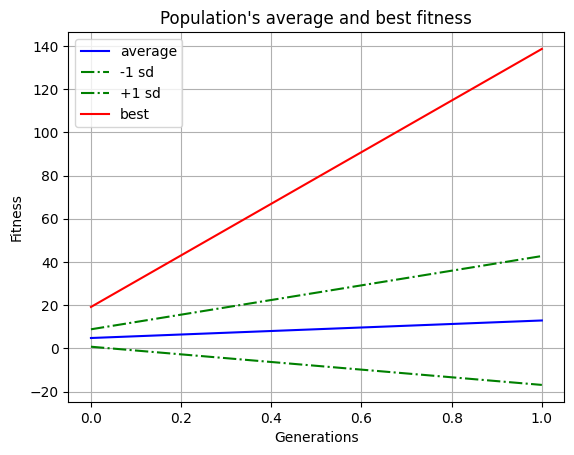

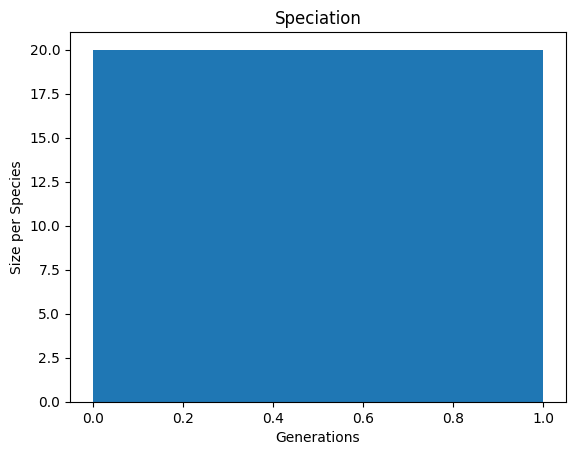

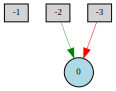

In [10]:
#NEAT setup
def run_neat_setup(config_file_path):
    # Load NEAT configuration
    neat_config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                                     config_file_path)

    # Initialize NEAT population
    population = neat.Population(neat_config)

    # Add console output and statistics reporters
    population.add_reporter(neat.StdOutReporter(True))
    statistics_reporter = neat.StatisticsReporter()
    population.add_reporter(statistics_reporter)

    # Run the simulation for up to 50 generations
    champion_genome = population.run(main, 50)

    # Visualize the best genome
    #https://github.com/CodeReclaimers/neat-python/blob/master/examples/xor/visualize.py
    visualize.draw_net(neat_config, champion_genome, view=False)
    visualize.plot_stats(statistics_reporter, ylog=False, view=True)
    visualize.plot_species(statistics_reporter, view=True)

    display(SVG(filename='Digraph.gv.svg'))

# Entry point of the script
if __name__ == "__main__":
    directory = os.getcwd()
    configuration_path = os.path.join(directory, "config.txt")
    run_neat_setup(configuration_path)